In [1]:
#import packages needed
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import os
import glob as glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

In [2]:
#decompose advection terms into ubar u' dtdxbar dtxdx'

#do wrt to monthly mean and wrt to annual mean


In [5]:
#functions that get each heat budget variable calculated.
#general form so can use any dataset
def diff_T(T):
    dTdt = T.differentiate(coord = 'time',datetime_unit= 's')
    dTdx = T.differentiate('lon') / (110e3 * np.cos(T.lat * np.pi / 180))
    dTdy = T.differentiate('lat') / (110e3 )
    dTdz = (T[:,0] - T[:,-1])/float(T.level[-1])
    return dTdt[:,:-1], dTdx[:,:-1], dTdy[:,:-1], dTdz

def advection(u, v, w, dx, dy, dz):
    uadv = u*dx
    vadv = v*dy
    wadv = w*dz
    return uadv, vadv, wadv

def get_weights(INP):
    weights = INP.level
    #add a 0m surface layer
    wt=np.array([0.])
    for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
    thickness = wt[1:]-wt[:-1]
    thickness_DA = xr.DataArray(thickness, coords={'level': INP.level},
                 dims=['level'])
    return thickness_DA

def weighted_avg(inp, weights):
    avg=inp.weighted(weights).mean('level')
    return avg


def get_clim(dict_name):
    dict1={}
    #unpack dict, get climatology, repack
    for key in dict_name.keys():
        var = dict_name[key]
        var = var.groupby('time.month').mean('time')
        dict1[key] = var
    return dict1


In [22]:
#now do the same for ec-earth3
T = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/THETAO/*.nc', parallel=True).thetao
U = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/UO/*.nc', parallel=True).uo
V = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/VO/*.nc', parallel=True).vo
#W = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/WO/*.nc').wo
Q = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/HFDS/*.nc', parallel=True).hfds
SW = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/RSNTDS/*.nc', parallel=True).rsntds
#get only to 50m
T50 = T[:,:5]
U50 = U[:,:5]
V50 = V[:,:5]
#W = W[:,4]
#now put lat lon of uvw to T
UC = U.assign_coords({'lat': T.lat, 'lon': T.lon})
VC = V.assign_coords({'lat': T.lat, 'lon': T.lon})
#W = W.assign_coords({'lat': T.lat, 'lon': T.lon})
#rename lev coord to level
#T = T.rename({'lev':'level'})
#U = U.rename({'lev':'level'})
#V = V.rename({'lev':'level'})
#W = W.rename({'lev':'level'})

In [23]:
T = T.sel(lat=slice(-40,-20),lon=slice(30,60))
U = U.sel(lat=slice(-40,-20),lon=slice(30,60))
V = V.sel(lat=slice(-40,-20),lon=slice(30,60))
UC = UC.sel(lat=slice(-40,-20),lon=slice(30,60))
VC = VC.sel(lat=slice(-40,-20),lon=slice(30,60))


In [27]:
#set temperature interface to 0 in T U and V
T0 = T.fillna(0)
U0 = U.fillna(0)
V0 = V.fillna(0)

In [28]:
dTdx = T0.differentiate('lon') / (110e3 * np.cos(T0.lat * np.pi / 180))
dTdy = T0.differentiate('lat') / (110e3 )

In [35]:
dTdxNA = T.differentiate('lon') / (110e3 * np.cos(T.lat * np.pi / 180))


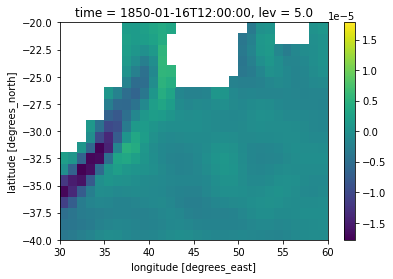

In [36]:
dTdxNA[0,0].plot(cmap = 'viridis')

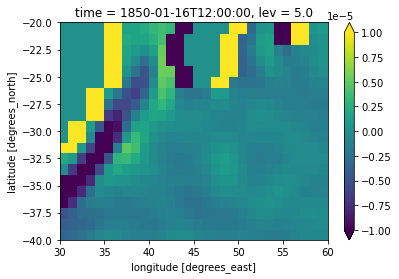

In [62]:
dTdx[0,0].plot(cmap = 'viridis', vmin = -1e-5,vmax = 1e-5)

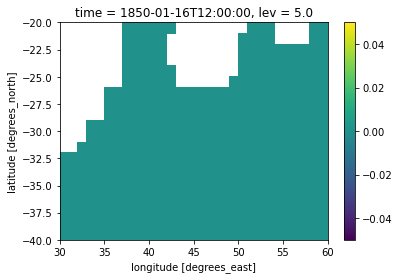

In [59]:
(dTdxNA-dTdx)[0,0].plot(cmap = 'viridis')

In [56]:
dTdx[0,0].values

array([[-3.61514150e-06, -3.18854325e-06, -2.45317587e-06,
        -1.69760665e-06, -9.60374136e-07, -5.13270679e-07,
        -5.84370387e-07, -1.14166266e-06, -1.55711506e-06,
        -1.59703562e-06, -1.44655547e-06, -1.08429302e-06,
        -5.88291657e-07, -3.62037735e-07, -5.28888346e-07,
        -8.95173187e-07, -1.23794164e-06, -1.39397224e-06,
        -1.44898238e-06, -1.36002910e-06, -1.21712183e-06,
        -1.30451335e-06, -1.52140791e-06, -1.66843869e-06,
        -1.75627964e-06, -1.46142034e-06, -1.04650725e-06,
        -8.04983972e-07, -6.32369431e-07, -6.27942553e-07],
       [-4.10144587e-06, -3.78132368e-06, -3.38081920e-06,
        -2.94095444e-06, -2.22205594e-06, -1.56983618e-06,
        -1.29481270e-06, -1.47465364e-06, -1.79154105e-06,
        -2.00316490e-06, -1.90268705e-06, -1.63079865e-06,
        -1.22014669e-06, -9.97644206e-07, -1.28086544e-06,
        -1.70045739e-06, -1.94692168e-06, -1.90326311e-06,
        -1.90824823e-06, -1.93321814e-06, -1.73786794e-

In [57]:
dTdxNA[0,0].values

array([[-3.61514150e-06, -3.18854325e-06, -2.45317587e-06,
        -1.69760665e-06, -9.60374136e-07, -5.13270679e-07,
        -5.84370387e-07, -1.14166266e-06, -1.55711506e-06,
        -1.59703562e-06, -1.44655547e-06, -1.08429302e-06,
        -5.88291657e-07, -3.62037735e-07, -5.28888346e-07,
        -8.95173187e-07, -1.23794164e-06, -1.39397224e-06,
        -1.44898238e-06, -1.36002910e-06, -1.21712183e-06,
        -1.30451335e-06, -1.52140791e-06, -1.66843869e-06,
        -1.75627964e-06, -1.46142034e-06, -1.04650725e-06,
        -8.04983972e-07, -6.32369431e-07, -6.27942553e-07],
       [-4.10144587e-06, -3.78132368e-06, -3.38081920e-06,
        -2.94095444e-06, -2.22205594e-06, -1.56983618e-06,
        -1.29481270e-06, -1.47465364e-06, -1.79154105e-06,
        -2.00316490e-06, -1.90268705e-06, -1.63079865e-06,
        -1.22014669e-06, -9.97644206e-07, -1.28086544e-06,
        -1.70045739e-06, -1.94692168e-06, -1.90326311e-06,
        -1.90824823e-06, -1.93321814e-06, -1.73786794e-

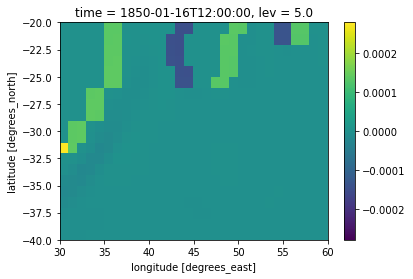

In [29]:
dTdx[0,0].plot(cmap = 'viridis')

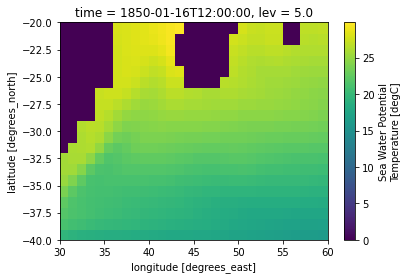

In [39]:
(T0)[0,0].plot(cmap = 'viridis')

In [73]:
uaNA = U0*dTdxNA
ua = U0*dTdx
ua1 = U*dTdxNA

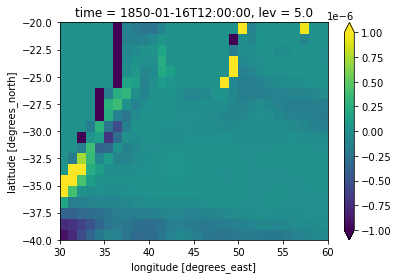

In [71]:
ua[0,0].plot(vmin = -1e-6, vmax = 1e-6)

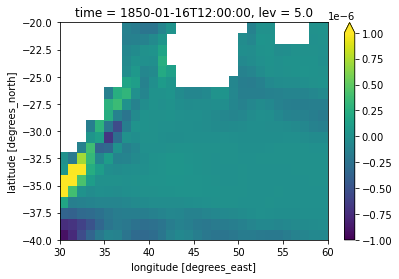

In [72]:
uaNA[0,0].plot(vmin = -1e-6, vmax = 1e-6)

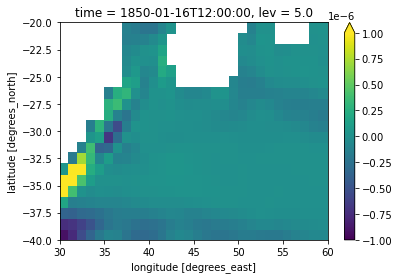

In [74]:
ua1[0,0].plot(vmin = -1e-6, vmax = 1e-6)

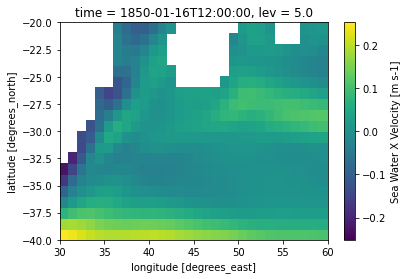

In [65]:
U[0,0].plot(cmap = 'viridis')

In [84]:
#calculate W term
#give U and V nans to 0
U0 = V.fillna(0)
V0 = U.fillna(0)
#first get dudx and dvdy
dudx = U0.differentiate(coord = 'lon') / (110e3 * np.cos(U0.lat * np.pi / 180))
dvdy = V0.differentiate(coord='lat') / (110e3)


weights = U.lev#add a 0m surface layer
wt=np.array([0.])
for i in range(len(weights.values)):
    NW = 2*weights.values[i]-wt[i]
    wt = np.insert(wt,i+1,NW)
thickness = wt[1:]-wt[:-1]
thickness_DA = xr.DataArray(thickness, coords={'lev': U.lev},
             dims=['lev'])
w_list = []


for i, j in enumerate(thickness_DA):
    if i == 0:
        w = (dudx[:,i]*j + dvdy[:,i]*j)
        #add to new DataArray with vertical coords put in
        w = w.assign_coords({'lev': thickness_DA.lev[i]})
        w_list.append(w)
    else:
        l = (dudx[:,i]*j + dvdy[:,i]*j) + w_list[i-1]
        w = l.assign_coords({'lev': thickness_DA.lev[i]})
        w_list.append(w)
#now put all layers into one array
w = xr.concat(w_list, dim = 'lev')

In [81]:
#calculate W term
#give U and V nans to 0
U0 = V.fillna(0)
V0 = U.fillna(0)
#first get dudx and dvdy
dudx = U.differentiate(coord = 'lon') / (110e3 * np.cos(U0.lat * np.pi / 180))
dvdy = V.differentiate(coord='lat') / (110e3)


weights = U.lev#add a 0m surface layer
wt=np.array([0.])
for i in range(len(weights.values)):
    NW = 2*weights.values[i]-wt[i]
    wt = np.insert(wt,i+1,NW)
thickness = wt[1:]-wt[:-1]
thickness_DA = xr.DataArray(thickness, coords={'lev': U.lev},
             dims=['lev'])
w_list = []


for i, j in enumerate(thickness_DA):
    if i == 0:
        w = (dudx[:,i]*j + dvdy[:,i]*j)
        #add to new DataArray with vertical coords put in
        w = w.assign_coords({'lev': thickness_DA.lev[i]})
        w_list.append(w)
    else:
        l = (dudx[:,i]*j + dvdy[:,i]*j) + w_list[i-1]
        w = l.assign_coords({'lev': thickness_DA.lev[i]})
        w_list.append(w)
#now put all layers into one array
w_ = xr.concat(w_list, dim = 'lev')

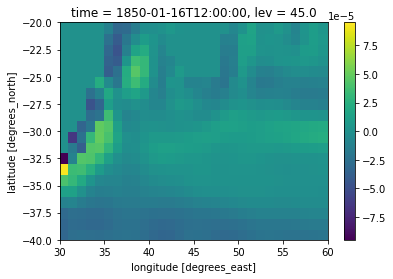

In [89]:
w[4,0].plot(cmap = 'viridis')

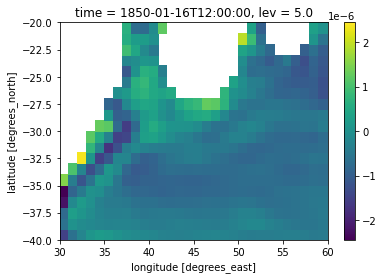

In [86]:
w_[0,0].plot(cmap = 'viridis')

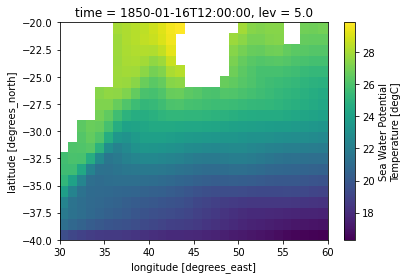

In [11]:
T[0,0].plot(cmap = 'viridis')

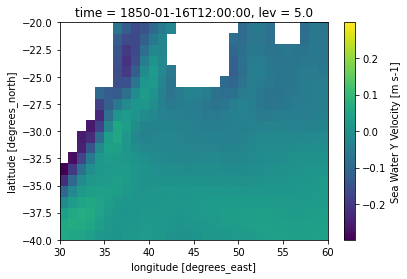

In [6]:
V[0,0].plot(cmap='viridis')

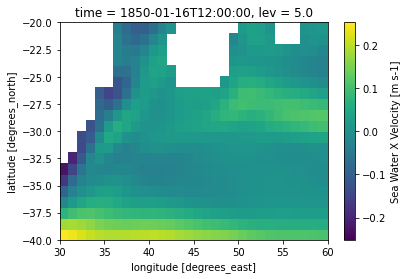

In [27]:
U[0,0].plot(cmap='viridis')

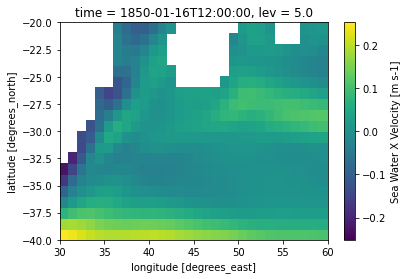

In [28]:
UC[0,0].plot(cmap='viridis')

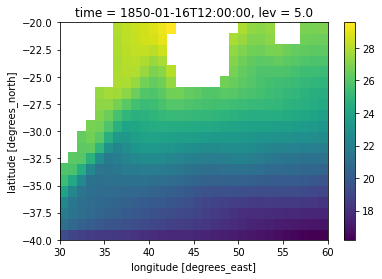

In [12]:
(T[0,0]-U[0,0]).plot(cmap='viridis')

In [91]:
T1 = insert_level(T)

In [133]:
def get_weights(INP):
    weights = INP.lev
    #add a 0m surface layer
    wt=np.array([0.])
    for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
    thickness = wt[1:]-wt[:-1]
    thickness_DA = xr.DataArray(thickness, coords={'lev': INP.lev},
                 dims=['lev'])
    return thickness_DA

def weighted_avg(inp, weights):
    avg=inp.weighted(weights).mean('lev')
    return avg


dTdt = T.differentiate(coord = 'time', datetime_unit= 's')
weights = get_weights(T)
#now get wtd avg
dTdt_ = weighted_avg(dTdt, weights)

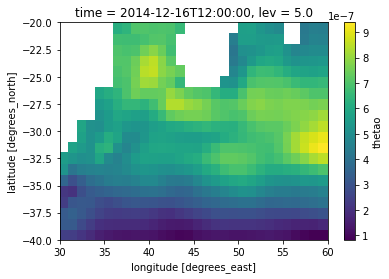

In [155]:
dTdt[-1,0].plot()

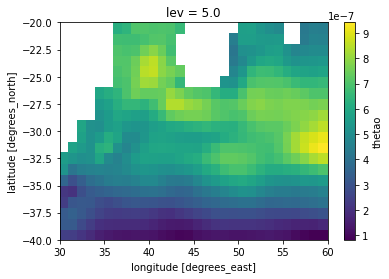

In [156]:
((T[1979,0] - T[1978,0])/(365/12*24*60*60)).plot()

In [173]:
dtdx2 = T.differentiate('lon', edge_order=2)
dtdx1 = T.differentiate('lon', edge_order=1)

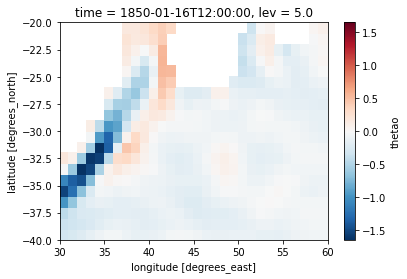

In [170]:
dtdx1[0,0].plot()

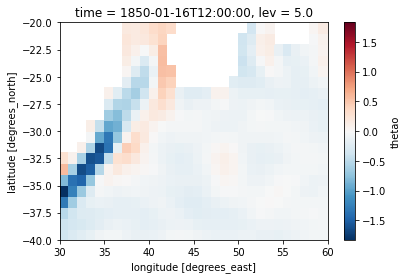

In [171]:
dtdx2[0,0].plot()

In [ ]:
#calculate W term
#give U and V nans to 0

#first get dudx and dvdy
dudx = U.differentiate(coord = 'lon') / (110e3 * np.cos(U.lat * np.pi / 180))
dvdy = V.differentiate(coord='lat') / (110e3)


weights = U.level#add a 0m surface layer
wt=np.array([0.])
for i in range(len(weights.values)):
    NW = 2*weights.values[i]-wt[i]
    wt = np.insert(wt,i+1,NW)
thickness = wt[1:]-wt[:-1]
thickness_DA = xr.DataArray(thickness, coords={'level': U.level},
             dims=['level'])
w_list = []
print(thickness_DA.level)


for i, j in enumerate(thickness_DA):
    if i == 0:
        w = (dudx[:,i]*j + dvdy[:,i]*j)
        #add to new DataArray with vertical coords put in
        w = w.assign_coords({'level': thickness_DA.level[i]})
        w_list.append(w)
    else:
        l = (dudx[:,i]*j + dvdy[:,i]*j) + w_list[i-1]
        w = l.assign_coords({'level': thickness_DA.level[i]})
        w_list.append(w)
#now put all layers into one array
w = xr.concat(w_list, dim = 'level')

In [25]:
W = w

In [26]:
W = W[4,:]


In [27]:
W

<xarray.DataArray (time: 1980, lat: 180, lon: 360)>
dask.array<getitem, shape=(1980, 180, 360), dtype=float64, chunksize=(120, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    level    float64 45.0

In [28]:
dTdtg, dTdxg, dTdyg, dTdzg = diff_T(T)

In [29]:
uadvg, vadvg, wadvg = advection(U, V, W, dTdxg, dTdyg, dTdzg)

In [30]:
gqnet = (Q-SW*((0.67*np.exp(-50))+((1-0.67)*np.exp(-50/17))))/(3986*1026*50)

In [31]:
#calcualate weights of levels
weights = get_weights(T)
#now get wtd avg
dTdt_gw = weighted_avg(dTdtg, weights)
uwg = weighted_avg(uadvg, weights)
vwg = weighted_avg(vadvg, weights)
wwg = wadvg

In [32]:
#alse get weighted avergae of u cur, v cur, and dtdx and dtdy
#decompose advection terms to see where the bias is coming from - temp or current
#GODAS
dTdxgw = weighted_avg(dTdxg, weights)
dTdygw = weighted_avg(dTdyg, weights)

gUw = weighted_avg(U, weights)
gVw = weighted_avg(V, weights)

In [33]:
#now calcaulte cliamotlogy of terms
dT_c = dTdt_gw.groupby('time.month').mean('time')
u_c = uwg.groupby('time.month').mean('time')
v_c = vwg.groupby('time.month').mean('time')
w_c = wwg.groupby('time.month').mean('time')
q_c = gqnet.groupby('time.month').mean('time')

In [34]:
dxgC = dTdxgw.groupby('time.month').mean('time')
dygC = dTdygw.groupby('time.month').mean('time')
dzgC = dTdzg.groupby('time.month').mean('time')
ugC = gUw.groupby('time.month').mean('time')
vgC = gVw.groupby('time.month').mean('time')
wgC = W.groupby('time.month').mean('time')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


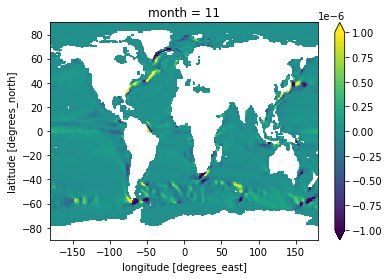

In [54]:
u_c[10].plot(vmin = -1e-6, vmax = 1e-6,cmap = 'viridis')

In [55]:
#now save data
#now convert to netcdf
dT_c.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/climatology/AC_dtdt.nc')
u_c.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/climatology/AC_uadv.nc')
v_c.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/climatology/AC_vadv.nc')
w_c.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/climatology/AC_wadv.nc')
q_c.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/climatology/AC_qnet.nc')
dxgC.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/climatology/AC_dtdx.nc')
dygC.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/climatology/AC_dtdy.nc')
dzgC.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/climatology/AC_dtdz.nc')
ugC.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/climatology/AC_ucur.nc')
vgC.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/climatology/AC_vcur.nc')
wgC.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/climatology/AC_wcur.nc')



/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.

In [1]:
def plot_background(ax, i, j):
    #for use with plotting 12 months. need to change 
    ax.set_extent([30., 125., -30., 20.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.LAND)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5,)
    gl.top_labels = False
    gl.right_labels = False
    if i == 5:
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    if j > 0:
        gl.left_labels = False
    return ax
def plot_var(vari, vmin, vmax, name):
    lons = vari.lon
    lats = vari.lat
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 15), sharey='all', sharex='all', 
                                 subplot_kw={'projection':ccrs.PlateCarree()})
    for i in range(0,6):

        axes[i, 0].pcolormesh(lons, lats, (vari).sel(month = i+1), cmap = 'RdBu_r', 
                                    vmin = vmin, vmax = vmax, 
                                    transform=ccrs.PlateCarree())
        plot_background(axes[i,0], i, 0)
        mon = i+1
        axes[i, 0].set_title('Month = '+str(mon))
        #2nd collumn
        im = axes[i, 1].pcolormesh(lons, lats, (vari).sel(month = i+7), cmap = 'RdBu_r', 
                                    #colorbar=True, 
                                    vmin = vmin, vmax = vmax, 
                                    transform=ccrs.PlateCarree())
        plot_background(axes[i,1], i, 1)
        mon2 = i+7
        axes[i, 1].set_title('Month = '+str(mon2))
    cbar_ax = fig.add_axes([0.95, 0.45, 0.05, 0.25])
    fig.colorbar(im, cax=cbar_ax)
    axes[0,0].text(1.5,1.3, name, va='bottom', ha='center', fontsize = 'x-large',
            rotation='horizontal', rotation_mode='anchor',
            transform=axes[0,0].transAxes)
    return fig